Name | Matr.Nr. | Due Date
:--- | ---: | ---:
Aral Cimcim | k11720457 | 25.05.2023, 08:00

<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 5 – Language Modeling with LSTM (Assignment)</h2>

<b>Authors:</b> N. Rekabsaz, B. Schäfl, S. Lehner, J. Brandstetter, E. Kobler, M. Abbass, A. Schörgenhumer<br>
<b>Date:</b> 16-05-2023

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>
<p><p>This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which might require small code modifications. Most/All of the used functions are imported from the file <code>u5_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u5_utils.py</code> need to be installed.</p></p>

In [985]:
import u5_utils as u5

import numpy as np
import torch
import os
import time
import math
import ipdb
import matplotlib.pyplot as plt
import seaborn as sns

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u5.setup_jupyter()

# Check minimum versions.
u5.check_module_versions()

Installed Python version: 3.8 (✓)
Installed numpy version: 1.23.5 (✓)
Installed pandas version: 2.0.1 (✓)
Installed PyTorch version: 2.0.1+cu117 (✓)


<h2>Language Model Training and Evaluation</h2>

<h3 style="color:rgb(0,120,170)">Data & Dictionary Preperation</h3>

<div class="alert alert-warning">
    <b>Exercise 1. [20 Points]</b>
        <ul>
            <li>Setup the data set using the same parameter settings as in the main exercise notebook but with the changes mentioned below.</li>
            <li>Change the batch size in the initial parameters to $64$ and observe its effect on the created batches. Explain how the corpora are transformed into batches.</li>
            <li>Use a seed of $23$.</li>
            <li>For a specific sequence in <code>val_data_splits</code> (e.g., index $15$), print the corresponding words of its first 25 wordIDs.</li>
        </ul>
</div>

In [986]:
# Input & output parameters
data_path = os.path.join("resources", "penn")
save_path = "model.pt"

# Training & evaluation parameters
train_batch_size = 64 
eval_batch_size = 64 
max_seq_len = 40 

# Random seed to facilitate reproducibility
torch.manual_seed(23)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device:", device)

Device: cuda


In [987]:
train_corpus = u5.Corpus(os.path.join(data_path, "train.txt"))
valid_corpus = u5.Corpus(os.path.join(data_path, "valid.txt"))
test_corpus = u5.Corpus(os.path.join(data_path, "test.txt"))

dictionary = u5.Dictionary()
train_corpus.fill_dictionary(dictionary)
ntokens = len(dictionary)

train_data = train_corpus.words_to_ids(dictionary)
valid_data = valid_corpus.words_to_ids(dictionary)
test_data = test_corpus.words_to_ids(dictionary)

train_data_splits = u5.batchify(train_data, train_batch_size, device)
val_data_splits = u5.batchify(valid_data, eval_batch_size, device)
test_data_splits = u5.batchify(test_data, eval_batch_size, device)

# Check the tokens of train, test, val
print("Train data:", len(train_data))
print("Validation data:", len(valid_data))
print(f"Test data: {len(test_data)}\n")

# For the 15th batch in val_data_splits, first 25 words
words = [dictionary.idx2word[i] for i in val_data_splits[:25, 15]]
IDs = val_data_splits[:25, 15]

# Print the IDs
for word, ID in zip(words, IDs):
    print(f"{word} | ID:{ID}")

Train data: 929589
Validation data: 73760
Test data: 82430

weekly | ID:4535
reports | ID:1363
on | ID:153
school | ID:2052
and | ID:49
college | ID:263
construction | ID:1021
plans | ID:746
<eos> | ID:25
market | ID:393
data | ID:1420
<unk> | ID:27
is | ID:41
a | ID:36
<unk> | ID:27
of | ID:43
educational | ID:2970
information | ID:157
and | ID:49
provides | ID:4191
related | ID:869
services | ID:3156
<eos> | ID:25
closely | ID:193
held | ID:629


Using the batchify function, batch sizes divide the data sets as (N // B, B):

for train --> (14524, 64) first N = 929.536 samples 

for val --> (1152, 64) first N = 73.728 samples

for test --> (1287, 64) first N = 82.368 samples

<div class="alert alert-warning">
    <b>Exercise 2. [20 Points]</b>
        <ul>
            <li>Copy the implementation of <code>LM_LSTMModel</code> from the main exercise notebook but make the following changes:</li>
            <ul>
                <li>Add an integer parameter to <code>LM_LSTMModel</code>'s initialization, called <code>num_layers</code> which indicates the number of (vertically) stacked LSTM blocks. Hint: PyTorch's LSTM implementation directly supports this, so you simply have to set it when creating the LSTM instance (see parameter <code>num_layers</code> in the <a href="https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html">documentation</a>).</li>
                <li>Add a new bool parameter to <code>LM_LSTMModel</code>'s initialization, called <code>tie_weights</code>. Extend the implementation of <code>LM_LSTMModel</code> such that if <code>tie_weights</code> is set to <code>True</code>, the model ties/shares the parameters of <code>encoder</code> with the ones of <code>decoder</code>. Consider that <code>encoder</code> and <code>decoder</code> still remain separate components but their parameters are now the same (shared). This process is called <i>weight tying</i>. Feel free to search the internet for relevant resources and implementation hints.</li>
            </ul>
            <li>Create four models:</li>
            <ul>
                <li>1 layer and without weight tying</li>
                <li>1 layer and with weight tying</li>
                <li>2 layers and without weight tying</li>
                <li>2 layers and with weight tying</li>
            </ul>
            <li>Compare the number of parameters of the models and report your observations.</li>
        </ul>
</div>

In [988]:
# LSTM model without weight tying, 1 layer
class LM_LSTMModel_1(torch.nn.Module):
    
    def __init__(self, ntoken, ninp, nhid, num_layers, tie_weights):
        super().__init__()
        self.ntoken = ntoken
        self.encoder = torch.nn.Embedding(ntoken, ninp) 
        self.rnn = torch.nn.LSTM(ninp, nhid, num_layers)
        self.decoder = torch.nn.Linear(nhid, ntoken)
        if tie_weights:
            self.decoder.weight = self.encoder.weight

    def forward(self, input, hidden=None, return_logs=True):
        emb = self.encoder(input)
        hiddens, last_hidden = self.rnn(emb, hidden)
        
        decoded = self.decoder(hiddens)
        if return_logs:
            y_hat = torch.nn.LogSoftmax(dim=-1)(decoded)
        else:
            y_hat = torch.nn.Softmax(dim=-1)(decoded)
        #ipdb.set_trace()
        return y_hat, last_hidden
    
# sub_sequence length of 40 -->  input (40, 64) --> emb (40, 64, 200) --> last hidden (1, 64, 200) --> decoded (40, 64, 10001)

In [989]:
# Model parameters
emsize = 200  # size of word embeddings
nhid = 200  # number of hidden units per layer
num_layers = 1 # number of layers
tie_weights = False # share the weights or not

model_1 = LM_LSTMModel_1(ntokens, emsize, nhid, num_layers, tie_weights)
model_1.to(device)

print(f"Model: {model_1}")
print(f"Model total trainable parameters: {sum(p.numel() for p in model_1.parameters() if p.requires_grad)}")

Model: LM_LSTMModel_1(
  (encoder): Embedding(10001, 200)
  (rnn): LSTM(200, 200)
  (decoder): Linear(in_features=200, out_features=10001, bias=True)
)
Model total trainable parameters: 4332001


In [990]:
# LSTM model with weight tying, 1 layer
class LM_LSTMModel_2(torch.nn.Module):
    
    def __init__(self, ntoken, ninp, nhid, num_layers, tie_weights):
        super().__init__()
        self.ntoken = ntoken
        self.encoder = torch.nn.Embedding(ntoken, ninp) 
        self.rnn = torch.nn.LSTM(ninp, nhid, num_layers)
        self.decoder = torch.nn.Linear(nhid, ntoken) 
        if tie_weights:
            self.decoder.weight = self.encoder.weight

    def forward(self, input, hidden=None, return_logs=True):
        emb = self.encoder(input)
        hiddens, last_hidden = self.rnn(emb, hidden)
        decoded = self.decoder(hiddens)
        if return_logs:
            y_hat = torch.nn.LogSoftmax(dim=-1)(decoded)
        else:
            y_hat = torch.nn.Softmax(dim=-1)(decoded)
        #ipdb.set_trace()
        return y_hat, last_hidden
    
# sub_sequence length of 40 -->  input (40, 64) --> emb (40, 64, 200) --> last hidden (1, 64, 200) --> decoded (40, 64, 10001)

In [991]:
# Model parameters
emsize = 200  # size of word embeddings
nhid = 200  # number of hidden units per layer
num_layers = 1 # number of layers
tie_weights = True # share the weights or not

model_2 = LM_LSTMModel_2(ntokens, emsize, nhid, num_layers, tie_weights)
model_2.to(device)

print(f"Model: {model_2}")
print(f"Model total trainable parameters: {sum(p.numel() for p in model_2.parameters() if p.requires_grad)}")

Model: LM_LSTMModel_2(
  (encoder): Embedding(10001, 200)
  (rnn): LSTM(200, 200)
  (decoder): Linear(in_features=200, out_features=10001, bias=True)
)
Model total trainable parameters: 2331801


In [992]:
# LSTM model without weight tying, 2 layers
class LM_LSTMModel_3(torch.nn.Module):
    
    def __init__(self, ntoken, ninp, nhid, num_layers, tie_weights):
        super().__init__()
        self.ntoken = ntoken
        self.encoder = torch.nn.Embedding(ntoken, ninp) 
        self.rnn = torch.nn.LSTM(ninp, nhid, num_layers)
        self.decoder = torch.nn.Linear(nhid, ntoken) 
        if tie_weights:
            self.decoder.weight = self.encoder.weight

    def forward(self, input, hidden=None, return_logs=True):
        emb = self.encoder(input)
        hiddens, last_hidden = self.rnn(emb, hidden)
        decoded = self.decoder(hiddens)
        if return_logs:
            y_hat = torch.nn.LogSoftmax(dim=-1)(decoded)
        else:
            y_hat = torch.nn.Softmax(dim=-1)(decoded)
        #ipdb.set_trace()
        return y_hat, last_hidden
    
# sub_sequence length of 40 -->  input (40, 64) --> emb (40, 64, 200) --> last hidden (2, 64, 200) --> decoded (40, 64, 10001)

In [993]:
# Model parameters
emsize = 200  # size of word embeddings
nhid = 200  # number of hidden units per layer
num_layers = 2 # number of layers
tie_weights = False # share the weights or not

model_3 = LM_LSTMModel_3(ntokens, emsize, nhid, num_layers, tie_weights)
model_3.to(device)

print(f"Model: {model_3}")
print(f"Model total trainable parameters: {sum(p.numel() for p in model_3.parameters() if p.requires_grad)}")

Model: LM_LSTMModel_3(
  (encoder): Embedding(10001, 200)
  (rnn): LSTM(200, 200, num_layers=2)
  (decoder): Linear(in_features=200, out_features=10001, bias=True)
)
Model total trainable parameters: 4653601


In [994]:
# LSTM model with weight tying, 2 layers
class LM_LSTMModel_4(torch.nn.Module):
    
    def __init__(self, ntoken, ninp, nhid, num_layers, tie_weights):
        super().__init__()
        self.ntoken = ntoken
        self.encoder = torch.nn.Embedding(ntoken, ninp) 
        self.rnn = torch.nn.LSTM(ninp, nhid, num_layers)
        self.decoder = torch.nn.Linear(nhid, ntoken) 
        if tie_weights:
            self.decoder.weight = self.encoder.weight

    def forward(self, input, hidden=None, return_logs=True):
        emb = self.encoder(input)
        hiddens, last_hidden = self.rnn(emb, hidden)
        decoded = self.decoder(hiddens)
        if return_logs:
            y_hat = torch.nn.LogSoftmax(dim=-1)(decoded)
        else:
            y_hat = torch.nn.Softmax(dim=-1)(decoded)
        #ipdb.set_trace()
        return y_hat, last_hidden
    
# sub_sequence length of 40 -->  input (40, 64) --> emb (40, 64, 200) --> last hidden (2, 64, 200) --> decoded (40, 64, 10001)

In [995]:
# Model parameters
emsize = 200  # size of word embeddings
nhid = 200  # number of hidden units per layer
num_layers = 2 # number of layers
tie_weights = True # weight matrices of the input and output embeddings

model_4 = LM_LSTMModel_4(ntokens, emsize, nhid, num_layers, tie_weights)
model_4.to(device)

print(f"Model: {model_4}")
print(f"Model total trainable parameters: {sum(p.numel() for p in model_4.parameters() if p.requires_grad)}")

Model: LM_LSTMModel_4(
  (encoder): Embedding(10001, 200)
  (rnn): LSTM(200, 200, num_layers=2)
  (decoder): Linear(in_features=200, out_features=10001, bias=True)
)
Model total trainable parameters: 2653401


Trainable Parameters:

LSTM_1 (1 layer and without weight tying) 4332001 

LSTM_2 (1 layer and with weight tying) 2331801

LSTM_3 (2 layers and without weight tying) 4653601

LSTM_4 (2 layers and with weight tying) 2653401

In each case, weight tying reduces the trainable parameters almost by half, as the weights are shared, this is the expected behavior.

Increasing the layer size increases the number of trainable parameters, but the increase here is not so drastic.

<h3 style="color:rgb(0,120,170)">Training and Evaluation</h3>


<div class="alert alert-warning">
    <b>Exercise 3. [30 Points]</b>
    <ul>
        <li>Using the same setup as in the main lecture/exercise notebook, train all four models for $5$ epochs.</li>
        <li>Using <code>ipdb</code>, look inside the <code>forward</code> function of <code>LM_LSTMModel</code> during training. Check the forward process from input to output particularly by looking at the shapes of tensors. Report the shape of all tensors used in <code>forward</code>. Try to translate the numbers into batches $B$ and sequence length $L$. For instance, if we know that the batch size is $B=32$, a tensor of shape $(32, 128, 3)$ can be interpreted as a batch of $32$ sequences with $3$ channels of size $L=128$. Thus, this tensor can be translated into $(32, 128, 3) \rightarrow (B, L, 3)$. Look at the <a href="https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html">official documentation</a> to understand the order of the dimensions.</li>
        <li>Evaluate the models. Compare the performances of all four models on the train, validation and test set (for the test set, use the best model according to the respective validation set performance), and report your observations. To do so, create a plot showing the following curves:</li>
        <ul>
            <li>Loss on each current training batch before every model update step as function of epochs</li>
            <li>Loss on the validation set at every epoch</li>
        </ul>
        <li>Comment on the results!</li>
    </ul>
</div>

LSTM_ 1 & LSTM_2 with 1 layer:

sub_sequence length of 40 -->  input (40, 64) --> emb (40, 64, 200) --> last hidden (1, 64, 200) --> decoded (40, 64, 10001)

LSTM_ 3 & LSTM_4 with 2 layers:

sub_sequence length of 40 -->  input (40, 64) --> emb (40, 64, 200) --> last hidden (2, 64, 200) --> decoded (40, 64, 10001)

In [996]:
torch.manual_seed(23)

CUT_AFTER_BATCHES = -1  # JUST FOR DEBUGGING: cut the loop after these number of batches. Set to -1 to ignore

model = model_1

save_path = "model_1.pt"

def train(model: torch.nn.Module, optimizer: torch.optim.Optimizer, dictionary: u5.Dictionary,
          max_seq_len: int, train_batch_size: int, train_data_splits,
          clipping: float, learning_rate: float, print_interval: int, epoch: int,
          criterion: torch.nn.Module = torch.nn.NLLLoss()):
    """
    Train the model. Training mode turned on to enable dropout.
    """
    model.train()
    total_loss = 0.0
    start_time = time.time()
    ntokens = len(dictionary)
    start_hidden = None
    n_batches = (train_data_splits.size(0) - 1) // max_seq_len
    
    for batch_i, i in enumerate(range(0, train_data_splits.size(0) - 1, max_seq_len)):
        batch_data, batch_targets = u5.get_batch(train_data_splits, i, max_seq_len)
        #ipdb.set_trace()
        
        # Don't forget it! Otherwise, the gradients are summed together!
        optimizer.zero_grad()
        
        # Repackaging batches only keeps the value of start_hidden and disconnects its computational graph.
        # If repackaging is not done the, gradients are calculated from the current point to the beginning
        # of the sequence which becomes computationally too expensive.
        if start_hidden is not None:
            start_hidden = u5.repackage_hidden(start_hidden)
        
        # Forward pass
        y_hat_logprobs, last_hidden = model(batch_data, start_hidden, return_logs=True)
        
        # Loss computation & backward pass
        y_hat_logprobs = y_hat_logprobs.view(-1, ntokens)
        loss = criterion(y_hat_logprobs, batch_targets.view(-1))
        loss.backward()
        
        # The last hidden states of the current step is set as the start hidden state of the next step.
        # This passes the information of the current batch to the next batch.
        start_hidden = last_hidden
        
        # Clipping gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping)
        
        # Updating parameters using SGD
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_i % print_interval == 0 and batch_i > 0:
            cur_loss = total_loss / print_interval
            elapsed = time.time() - start_time
            throughput = elapsed * 1000 / print_interval
            print(f"| epoch {epoch:3d} | {batch_i:5d}/{n_batches:5d} batches | lr {learning_rate:02.2f} | ms/batch {throughput:5.2f} "
                  f"| loss {cur_loss:5.2f} | perplexity {math.exp(cur_loss):8.2f}")
            total_loss = 0
            start_time = time.time()

            # Save all cur_loss values for each epoch
            with open("model_1_cur_losses", "a") as f:
                f.write(f"{cur_loss}\n")
        
        # Cuts the loop (only for debugging)
        if (CUT_AFTER_BATCHES != -1) and (batch_i >= CUT_AFTER_BATCHES):
            print(f"WARNING: Training is interrupted after {batch_i} batches")
            break
            

epochs = 5  # total number of training epochs
print_interval = 25  # print report statistics every x batches
lr = 20  # initial learning rate
clipping = 0.25  # gradient clipping
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

best_val_loss = None

# Loop over epochs.
for epoch in range(epochs):
    epoch_start_time = time.time()
    train(model, optimizer, dictionary, max_seq_len, train_batch_size, train_data_splits, clipping, lr, print_interval, epoch)
    val_loss = u5.evaluate(model, dictionary, max_seq_len, eval_batch_size, val_data_splits)
    
    print("-" * 100)
    print(f"| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s"
          f"| valid loss {val_loss:5.2f} | valid perplexity {math.exp(val_loss):8.2f}")
    print("-" * 100)

    # Save all loss values at end of epoch
    with open("model_1_val_losses", "a") as f:
        f.write(f"{val_loss}\n")
    
    # Save the model if the validation loss is the best we've seen so far.
    if not best_val_loss or val_loss < best_val_loss:
        with open(save_path, "wb") as f:
            torch.save(model, f)

        best_val_loss = val_loss

    else:
        # Anneal the learning rate if no improvement has been seen in the validation dataset.
        lr /= 4.0
        for g in optimizer.param_groups:
            g["lr"] = lr

| epoch   0 |    25/  363 batches | lr 20.00 | ms/batch 34.48 | loss  7.29 | perplexity  1465.42
| epoch   0 |    50/  363 batches | lr 20.00 | ms/batch 23.00 | loss  6.04 | perplexity   417.98
| epoch   0 |    75/  363 batches | lr 20.00 | ms/batch 23.44 | loss  5.84 | perplexity   345.17
| epoch   0 |   100/  363 batches | lr 20.00 | ms/batch 23.52 | loss  5.75 | perplexity   314.74
| epoch   0 |   125/  363 batches | lr 20.00 | ms/batch 23.56 | loss  5.65 | perplexity   284.47
| epoch   0 |   150/  363 batches | lr 20.00 | ms/batch 23.28 | loss  5.51 | perplexity   247.00
| epoch   0 |   175/  363 batches | lr 20.00 | ms/batch 23.64 | loss  5.59 | perplexity   267.49
| epoch   0 |   200/  363 batches | lr 20.00 | ms/batch 23.80 | loss  5.64 | perplexity   280.35
| epoch   0 |   225/  363 batches | lr 20.00 | ms/batch 23.84 | loss  5.58 | perplexity   265.66
| epoch   0 |   250/  363 batches | lr 20.00 | ms/batch 23.88 | loss  5.51 | perplexity   246.88
| epoch   0 |   275/  363 batc

In [997]:
torch.manual_seed(23)

CUT_AFTER_BATCHES = -1  # JUST FOR DEBUGGING: cut the loop after these number of batches. Set to -1 to ignore

model = model_2

save_path = "model_2.pt"

def train(model: torch.nn.Module, optimizer: torch.optim.Optimizer, dictionary: u5.Dictionary,
          max_seq_len: int, train_batch_size: int, train_data_splits,
          clipping: float, learning_rate: float, print_interval: int, epoch: int,
          criterion: torch.nn.Module = torch.nn.NLLLoss()):
    """
    Train the model. Training mode turned on to enable dropout.
    """
    model.train()
    total_loss = 0.0
    start_time = time.time()
    ntokens = len(dictionary)
    start_hidden = None
    n_batches = (train_data_splits.size(0) - 1) // max_seq_len
    
    for batch_i, i in enumerate(range(0, train_data_splits.size(0) - 1, max_seq_len)):
        batch_data, batch_targets = u5.get_batch(train_data_splits, i, max_seq_len)
        #ipdb.set_trace()
        
        # Don't forget it! Otherwise, the gradients are summed together!
        optimizer.zero_grad()
        
        # Repackaging batches only keeps the value of start_hidden and disconnects its computational graph.
        # If repackaging is not done the, gradients are calculated from the current point to the beginning
        # of the sequence which becomes computationally too expensive.
        if start_hidden is not None:
            start_hidden = u5.repackage_hidden(start_hidden)
        
        # Forward pass
        y_hat_logprobs, last_hidden = model(batch_data, start_hidden, return_logs=True)
        
        # Loss computation & backward pass
        y_hat_logprobs = y_hat_logprobs.view(-1, ntokens)
        loss = criterion(y_hat_logprobs, batch_targets.view(-1))
        loss.backward()
        
        # The last hidden states of the current step is set as the start hidden state of the next step.
        # This passes the information of the current batch to the next batch.
        start_hidden = last_hidden
        
        # Clipping gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping)
        
        # Updating parameters using SGD
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_i % print_interval == 0 and batch_i > 0:
            cur_loss = total_loss / print_interval
            elapsed = time.time() - start_time
            throughput = elapsed * 1000 / print_interval
            print(f"| epoch {epoch:3d} | {batch_i:5d}/{n_batches:5d} batches | lr {learning_rate:02.2f} | ms/batch {throughput:5.2f} "
                  f"| loss {cur_loss:5.2f} | perplexity {math.exp(cur_loss):8.2f}")
            total_loss = 0
            start_time = time.time()

            # Save all cur_loss values for each epoch
            with open("model_2_cur_losses", "a") as f:
                f.write(f"{cur_loss}\n")
        
        # Cuts the loop (only for debugging)
        if (CUT_AFTER_BATCHES != -1) and (batch_i >= CUT_AFTER_BATCHES):
            print(f"WARNING: Training is interrupted after {batch_i} batches")
            break
            

epochs = 5  # total number of training epochs
print_interval = 25  # print report statistics every x batches
lr = 20  # initial learning rate
clipping = 0.25  # gradient clipping
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

best_val_loss = None

# Loop over epochs.
for epoch in range(epochs):
    epoch_start_time = time.time()
    train(model, optimizer, dictionary, max_seq_len, train_batch_size, train_data_splits, clipping, lr, print_interval, epoch)
    val_loss = u5.evaluate(model, dictionary, max_seq_len, eval_batch_size, val_data_splits)
    
    print("-" * 100)
    print(f"| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s"
          f"| valid loss {val_loss:5.2f} | valid perplexity {math.exp(val_loss):8.2f}")
    print("-" * 100)

    # Save all loss values at end of epoch
    with open("model_2_val_losses", "a") as f:
        f.write(f"{val_loss}\n")
    
    # Save the model if the validation loss is the best we've seen so far.
    if not best_val_loss or val_loss < best_val_loss:
        with open(save_path, "wb") as f:
            torch.save(model, f)

        best_val_loss = val_loss

    else:
        # Anneal the learning rate if no improvement has been seen in the validation dataset.
        lr /= 4.0
        for g in optimizer.param_groups:
            g["lr"] = lr

| epoch   0 |    25/  363 batches | lr 20.00 | ms/batch 23.52 | loss  8.22 | perplexity  3724.14
| epoch   0 |    50/  363 batches | lr 20.00 | ms/batch 22.68 | loss  6.52 | perplexity   677.39
| epoch   0 |    75/  363 batches | lr 20.00 | ms/batch 22.68 | loss  6.34 | perplexity   566.14
| epoch   0 |   100/  363 batches | lr 20.00 | ms/batch 22.72 | loss  6.27 | perplexity   527.57
| epoch   0 |   125/  363 batches | lr 20.00 | ms/batch 22.68 | loss  6.19 | perplexity   486.44
| epoch   0 |   150/  363 batches | lr 20.00 | ms/batch 22.64 | loss  6.09 | perplexity   443.52
| epoch   0 |   175/  363 batches | lr 20.00 | ms/batch 22.68 | loss  6.18 | perplexity   482.98
| epoch   0 |   200/  363 batches | lr 20.00 | ms/batch 22.72 | loss  6.19 | perplexity   485.60
| epoch   0 |   225/  363 batches | lr 20.00 | ms/batch 22.72 | loss  6.15 | perplexity   466.96
| epoch   0 |   250/  363 batches | lr 20.00 | ms/batch 22.68 | loss  6.07 | perplexity   432.65
| epoch   0 |   275/  363 batc

In [998]:
torch.manual_seed(23)

CUT_AFTER_BATCHES = -1  # JUST FOR DEBUGGING: cut the loop after these number of batches. Set to -1 to ignore

model = model_3

save_path = "model_3.pt"

def train(model: torch.nn.Module, optimizer: torch.optim.Optimizer, dictionary: u5.Dictionary,
          max_seq_len: int, train_batch_size: int, train_data_splits,
          clipping: float, learning_rate: float, print_interval: int, epoch: int,
          criterion: torch.nn.Module = torch.nn.NLLLoss()):
    """
    Train the model. Training mode turned on to enable dropout.
    """
    model.train()
    total_loss = 0.0
    start_time = time.time()
    ntokens = len(dictionary)
    start_hidden = None
    n_batches = (train_data_splits.size(0) - 1) // max_seq_len
    
    for batch_i, i in enumerate(range(0, train_data_splits.size(0) - 1, max_seq_len)):
        batch_data, batch_targets = u5.get_batch(train_data_splits, i, max_seq_len)
        #ipdb.set_trace()
        
        # Don't forget it! Otherwise, the gradients are summed together!
        optimizer.zero_grad()
        
        # Repackaging batches only keeps the value of start_hidden and disconnects its computational graph.
        # If repackaging is not done the, gradients are calculated from the current point to the beginning
        # of the sequence which becomes computationally too expensive.
        if start_hidden is not None:
            start_hidden = u5.repackage_hidden(start_hidden)
        
        # Forward pass
        y_hat_logprobs, last_hidden = model(batch_data, start_hidden, return_logs=True)
        
        # Loss computation & backward pass
        y_hat_logprobs = y_hat_logprobs.view(-1, ntokens)
        loss = criterion(y_hat_logprobs, batch_targets.view(-1))
        loss.backward()
        
        # The last hidden states of the current step is set as the start hidden state of the next step.
        # This passes the information of the current batch to the next batch.
        start_hidden = last_hidden
        
        # Clipping gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping)
        
        # Updating parameters using SGD
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_i % print_interval == 0 and batch_i > 0:
            cur_loss = total_loss / print_interval
            elapsed = time.time() - start_time
            throughput = elapsed * 1000 / print_interval
            print(f"| epoch {epoch:3d} | {batch_i:5d}/{n_batches:5d} batches | lr {learning_rate:02.2f} | ms/batch {throughput:5.2f} "
                  f"| loss {cur_loss:5.2f} | perplexity {math.exp(cur_loss):8.2f}")
            total_loss = 0
            start_time = time.time()

            # Save all cur_loss values for each epoch
            with open("model_3_cur_losses", "a") as f:
                f.write(f"{cur_loss}\n")
        
        # Cuts the loop (only for debugging)
        if (CUT_AFTER_BATCHES != -1) and (batch_i >= CUT_AFTER_BATCHES):
            print(f"WARNING: Training is interrupted after {batch_i} batches")
            break
            

epochs = 5  # total number of training epochs
print_interval = 25  # print report statistics every x batches
lr = 20  # initial learning rate
clipping = 0.25  # gradient clipping
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

best_val_loss = None

# Loop over epochs.
for epoch in range(epochs):
    epoch_start_time = time.time()
    train(model, optimizer, dictionary, max_seq_len, train_batch_size, train_data_splits, clipping, lr, print_interval, epoch)
    val_loss = u5.evaluate(model, dictionary, max_seq_len, eval_batch_size, val_data_splits)
    
    print("-" * 100)
    print(f"| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s"
          f"| valid loss {val_loss:5.2f} | valid perplexity {math.exp(val_loss):8.2f}")
    print("-" * 100)

    # Save all loss values at end of epoch
    with open("model_3_val_losses", "a") as f:
        f.write(f"{val_loss}\n")
    
    # Save the model if the validation loss is the best we've seen so far.
    if not best_val_loss or val_loss < best_val_loss:
        with open(save_path, "wb") as f:
            torch.save(model, f)

        best_val_loss = val_loss

    else:
        # Anneal the learning rate if no improvement has been seen in the validation dataset.
        lr /= 4.0
        for g in optimizer.param_groups:
            g["lr"] = lr

| epoch   0 |    25/  363 batches | lr 20.00 | ms/batch 30.20 | loss  7.71 | perplexity  2238.54
| epoch   0 |    50/  363 batches | lr 20.00 | ms/batch 29.04 | loss  6.42 | perplexity   615.44
| epoch   0 |    75/  363 batches | lr 20.00 | ms/batch 29.00 | loss  6.11 | perplexity   451.24
| epoch   0 |   100/  363 batches | lr 20.00 | ms/batch 29.00 | loss  5.96 | perplexity   387.58
| epoch   0 |   125/  363 batches | lr 20.00 | ms/batch 29.04 | loss  5.83 | perplexity   339.83
| epoch   0 |   150/  363 batches | lr 20.00 | ms/batch 29.04 | loss  5.68 | perplexity   292.35
| epoch   0 |   175/  363 batches | lr 20.00 | ms/batch 29.08 | loss  5.73 | perplexity   308.96
| epoch   0 |   200/  363 batches | lr 20.00 | ms/batch 29.12 | loss  5.74 | perplexity   311.38
| epoch   0 |   225/  363 batches | lr 20.00 | ms/batch 29.04 | loss  5.70 | perplexity   297.55
| epoch   0 |   250/  363 batches | lr 20.00 | ms/batch 29.08 | loss  5.61 | perplexity   272.42
| epoch   0 |   275/  363 batc

In [999]:
torch.manual_seed(23)

CUT_AFTER_BATCHES = -1  # JUST FOR DEBUGGING: cut the loop after these number of batches. Set to -1 to ignore

model = model_4

save_path = "model_4.pt"

def train(model: torch.nn.Module, optimizer: torch.optim.Optimizer, dictionary: u5.Dictionary,
          max_seq_len: int, train_batch_size: int, train_data_splits,
          clipping: float, learning_rate: float, print_interval: int, epoch: int,
          criterion: torch.nn.Module = torch.nn.NLLLoss()):
    """
    Train the model. Training mode turned on to enable dropout.
    """
    model.train()
    total_loss = 0.0
    start_time = time.time()
    ntokens = len(dictionary)
    start_hidden = None
    n_batches = (train_data_splits.size(0) - 1) // max_seq_len
    
    for batch_i, i in enumerate(range(0, train_data_splits.size(0) - 1, max_seq_len)):
        batch_data, batch_targets = u5.get_batch(train_data_splits, i, max_seq_len)
        #ipdb.set_trace()
        
        # Don't forget it! Otherwise, the gradients are summed together!
        optimizer.zero_grad()
        
        # Repackaging batches only keeps the value of start_hidden and disconnects its computational graph.
        # If repackaging is not done the, gradients are calculated from the current point to the beginning
        # of the sequence which becomes computationally too expensive.
        if start_hidden is not None:
            start_hidden = u5.repackage_hidden(start_hidden)
        
        # Forward pass
        y_hat_logprobs, last_hidden = model(batch_data, start_hidden, return_logs=True)
        
        # Loss computation & backward pass
        y_hat_logprobs = y_hat_logprobs.view(-1, ntokens)
        loss = criterion(y_hat_logprobs, batch_targets.view(-1))
        loss.backward()
        
        # The last hidden states of the current step is set as the start hidden state of the next step.
        # This passes the information of the current batch to the next batch.
        start_hidden = last_hidden
        
        # Clipping gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping)
        
        # Updating parameters using SGD
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_i % print_interval == 0 and batch_i > 0:
            cur_loss = total_loss / print_interval
            elapsed = time.time() - start_time
            throughput = elapsed * 1000 / print_interval
            print(f"| epoch {epoch:3d} | {batch_i:5d}/{n_batches:5d} batches | lr {learning_rate:02.2f} | ms/batch {throughput:5.2f} "
                  f"| loss {cur_loss:5.2f} | perplexity {math.exp(cur_loss):8.2f}")
            total_loss = 0
            start_time = time.time()

            # Save all cur_loss values for each epoch
            with open("model_4_cur_losses", "a") as f:
                f.write(f"{cur_loss}\n")
        
        # Cuts the loop (only for debugging)
        if (CUT_AFTER_BATCHES != -1) and (batch_i >= CUT_AFTER_BATCHES):
            print(f"WARNING: Training is interrupted after {batch_i} batches")
            break
            

epochs = 5  # total number of training epochs
print_interval = 25  # print report statistics every x batches
lr = 20  # initial learning rate
clipping = 0.25  # gradient clipping
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

best_val_loss = None

# Loop over epochs.
for epoch in range(epochs):
    epoch_start_time = time.time()
    train(model, optimizer, dictionary, max_seq_len, train_batch_size, train_data_splits, clipping, lr, print_interval, epoch)
    val_loss = u5.evaluate(model, dictionary, max_seq_len, eval_batch_size, val_data_splits)
    
    print("-" * 100)
    print(f"| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s"
          f"| valid loss {val_loss:5.2f} | valid perplexity {math.exp(val_loss):8.2f}")
    print("-" * 100)

    # Save all loss values at end of epoch
    with open("model_4_val_losses", "a") as f:
        f.write(f"{val_loss}\n")
    
    # Save the model if the validation loss is the best we've seen so far.
    if not best_val_loss or val_loss < best_val_loss:
        with open(save_path, "wb") as f:
            torch.save(model, f)

        best_val_loss = val_loss

    else:
        # Anneal the learning rate if no improvement has been seen in the validation dataset.
        lr /= 4.0
        for g in optimizer.param_groups:
            g["lr"] = lr

| epoch   0 |    25/  363 batches | lr 20.00 | ms/batch 32.12 | loss  9.66 | perplexity 15710.09
| epoch   0 |    50/  363 batches | lr 20.00 | ms/batch 30.92 | loss  6.65 | perplexity   775.73
| epoch   0 |    75/  363 batches | lr 20.00 | ms/batch 30.72 | loss  6.43 | perplexity   618.43
| epoch   0 |   100/  363 batches | lr 20.00 | ms/batch 30.72 | loss  6.31 | perplexity   550.70
| epoch   0 |   125/  363 batches | lr 20.00 | ms/batch 30.56 | loss  6.18 | perplexity   484.47
| epoch   0 |   150/  363 batches | lr 20.00 | ms/batch 30.76 | loss  6.04 | perplexity   418.22
| epoch   0 |   175/  363 batches | lr 20.00 | ms/batch 30.68 | loss  6.09 | perplexity   439.36
| epoch   0 |   200/  363 batches | lr 20.00 | ms/batch 30.56 | loss  6.07 | perplexity   431.50
| epoch   0 |   225/  363 batches | lr 20.00 | ms/batch 30.76 | loss  6.02 | perplexity   413.09
| epoch   0 |   250/  363 batches | lr 20.00 | ms/batch 30.48 | loss  5.93 | perplexity   377.31
| epoch   0 |   275/  363 batc

In [1000]:
# Load the saved models
model_1 = torch.load("model_1.pt")
model_2 = torch.load("model_2.pt")
model_3 = torch.load("model_3.pt")
model_4 = torch.load("model_4.pt")

models = [model_1, model_2, model_3, model_4]

# Load the benchmarks
for i, model in enumerate(models):
    test_loss = u5.evaluate(model, dictionary, max_seq_len, eval_batch_size, test_data_splits)
    print("=" * 100)
    print(f"Model {i+1} | Test loss {test_loss:5.2f} | test perplexity {math.exp(test_loss):5.2f}")
    print("=" * 100)

Model 1 | Test loss  5.30 | test perplexity 199.48
Model 2 | Test loss  5.70 | test perplexity 298.59
Model 3 | Test loss  5.14 | test perplexity 170.94
Model 4 | Test loss  5.30 | test perplexity 200.87


In [1015]:
# Convert data to numpy array
model_1_cur_loss = np.loadtxt("model_1_cur_losses", dtype=float)
model_2_cur_loss = np.loadtxt("model_2_cur_losses", dtype=float)
model_3_cur_loss = np.loadtxt("model_3_cur_losses", dtype=float)
model_4_cur_loss = np.loadtxt("model_4_cur_losses", dtype=float)

model_1_val_loss = np.loadtxt("model_1_val_losses", dtype=float)
model_2_val_loss = np.loadtxt("model_2_val_losses", dtype=float)
model_3_val_loss = np.loadtxt("model_3_val_losses", dtype=float)
model_4_val_loss = np.loadtxt("model_4_val_losses", dtype=float)

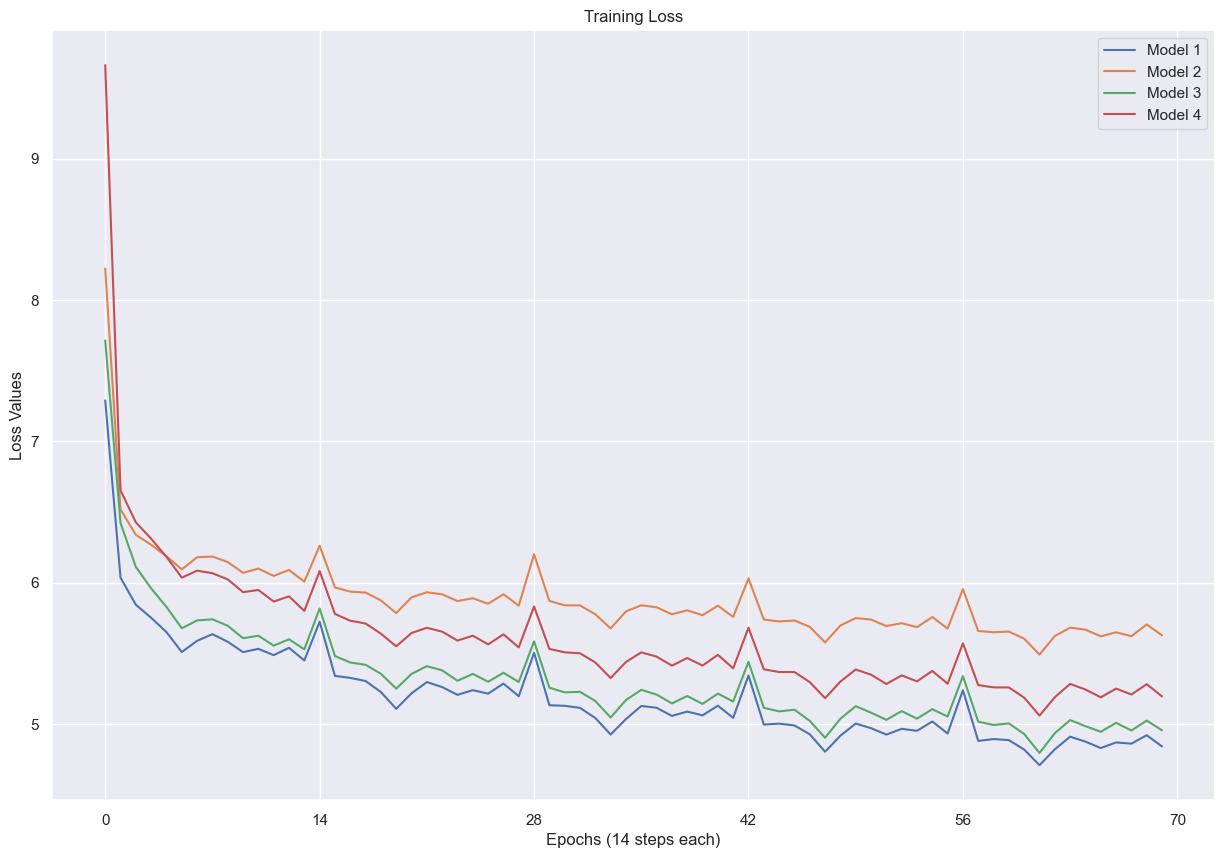

In [1016]:
# Plot the figures
plt.figure(figsize=(15, 10))
plt.plot(model_1_cur_loss, label="Model 1")
plt.plot(model_2_cur_loss, label="Model 2")
plt.plot(model_3_cur_loss, label="Model 3")
plt.plot(model_4_cur_loss, label="Model 4")
plt.title("Training Loss")
plt.xlabel("Epochs (14 steps each)")
plt.ylabel("Loss Values")
plt.xticks(np.arange(0, 71, 14))
plt.legend()

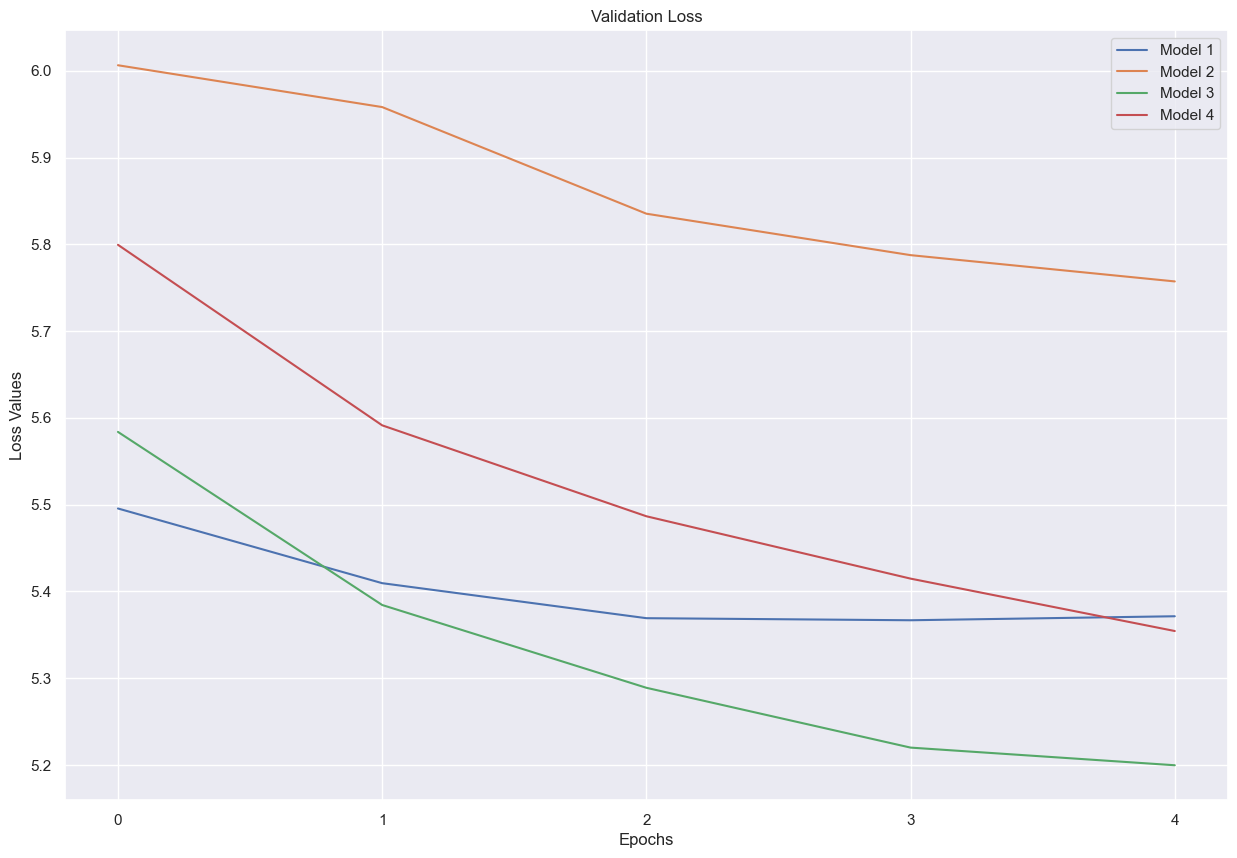

In [1019]:
# Plot the figures
plt.figure(figsize=(15, 10))
plt.plot(model_1_val_loss, label="Model 1")
plt.plot(model_2_val_loss, label="Model 2")
plt.plot(model_3_val_loss, label="Model 3")
plt.plot(model_4_val_loss, label="Model 4")
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss Values")
plt.xticks(np.arange(0, 5, 1))
plt.legend()

with $e^{x} $ = y;  where x = Test loss  5.08,  y = test perplexity 161.31

The best performing model is model_3 with the least loss and lowest perplexity.

Increasing the layer size, increased the model performance.

Perplexity and loss increased with weight-tying.

<h2>Language Generation</h2>

<div class="alert alert-warning">
    <b>Exercise 4. [30 Points]</b>
    <p>
    Copy the language generation code from the main exercise notebook and perform the following tasks:
    </p>
        <ul>
            <li>Compare all four previous models by generating $12$ words that append the starting word <tt>"despite"</tt>.</li>
            <li>For each model, retrieve the top $10$ wordIDs with the highest probabilities from the generated probability distribution (<code>prob_dist</code>) following the starting word <tt>"despite"</tt>. Fetch the corresponding words of these wordIDs. Do you observe any specific linguistic characteristic common between these words?</li>
            <li>The implementation in the main exercise notebook is based on sampling. Implement a second deterministic variant based on the <i>top-1</i> approach. In this particular variant, the generated word is the word with the highest probability in the predicted probability distribution. Repeat the same procedure as before (i.e., generate $12$ words that append the starting word <tt>"despite"</tt>).</li>
        </ul>
</div>

In [1006]:
#torch.manual_seed(23)

GENERATION_LENGTH = 12
START_WORD = "despite"

models = [model_1, model_2, model_3, model_4]

for model in models:
    start_hidden = None
    START_WORD = START_WORD.lower()
    generated_text = START_WORD

    with torch.no_grad():
        wordid_input = dictionary.word2idx[START_WORD]
        for i in range(0, GENERATION_LENGTH):
            data = u5.batchify(torch.tensor([wordid_input]), 1, device)

            y_hat_probs, last_hidden = model(data, start_hidden, return_logs=False)

            prob_dist = torch.distributions.Categorical(y_hat_probs.squeeze())
            wordid_input = prob_dist.sample()
            word_generated = dictionary.idx2word[wordid_input]
            
            generated_text += " " + word_generated

            start_hidden = last_hidden

        # Main sentence
        print("-" * 100)
        print(f"Model_{models.index(model)+1} | {generated_text}")
        print("-" * 100)


----------------------------------------------------------------------------------------------------
Model_1 | despite the foundations <eos> the <unk> price started the share <eos> control data
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Model_2 | despite a country and the miller their small transaction <eos> offset targeted 300-day
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Model_3 | despite it <eos> committing mr. <unk> first was named a director said the
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Model_4 | despite t

In [1014]:
#torch.manual_seed(23)

GENERATION_LENGTH = 12
START_WORD = "despite"

models = [model_1, model_2, model_3, model_4]

for model in models:
    start_hidden = None
    START_WORD = START_WORD.lower()
    generated_text = START_WORD

    with torch.no_grad():
        wordid_input = dictionary.word2idx[START_WORD]
        for i in range(0, GENERATION_LENGTH):
            data = u5.batchify(torch.tensor([wordid_input]), 1, device)

            y_hat_probs, last_hidden = model(data, start_hidden, return_logs=False)

            prob_dist = torch.distributions.Categorical(y_hat_probs.squeeze())

            # Probs of the top 10 words
            top10_IDs = prob_dist.probs.topk(10).indices
            top10_probs = prob_dist.probs.topk(10).values

            # Save the tensor to CPU --> to numpy
            top10_IDs = top10_IDs.cpu().numpy()
            top10_probs = top10_probs.cpu().numpy()

            # Convert word ids to words
            word_generated = [dictionary.idx2word[word] for word in top10_IDs]

            start_hidden = last_hidden

        # Metrics
        print(f"Model_{models.index(model)+1} | IDs: {top10_IDs}")
        print("-" * 100)
        print(f"Model_{models.index(model)+1} | Words: {word_generated}")
        print("-" * 100)
        print(f"Model_{models.index(model)+1} | Probs: {top10_probs}")
        print("-" * 100)
        

Model_1 | IDs: [ 36  33  27 110 129 988 308 248  28 499]
----------------------------------------------------------------------------------------------------
Model_1 | Words: ['a', 'the', '<unk>', 'its', 'an', 'his', 'some', 'one', 'N', 'federal']
----------------------------------------------------------------------------------------------------
Model_1 | Probs: [0.31637394 0.2751398  0.05039931 0.02725986 0.02586831 0.01104802
 0.00931311 0.00833753 0.00748378 0.00742241]
----------------------------------------------------------------------------------------------------
Model_2 | IDs: [ 33  36  27  25 110  88 417 129 557 102]
----------------------------------------------------------------------------------------------------
Model_2 | Words: ['the', 'a', '<unk>', '<eos>', 'its', 'with', '$', 'an', 'their', 'new']
----------------------------------------------------------------------------------------------------
Model_2 | Probs: [0.22941446 0.08445678 0.04057505 0.02159344 0.0196824

The highest probabilities are either for IDs 36,33,27: "the", "a", "unknown". Mostly articles and unknown words are predicted. The most frequent article in the corpus is "the".

It seems to me that neither of these models learn where to place the "eos" token to mark the beginning or end of sentences. (when the seed is set to 23)

Looking at the generated sentences; the third model seems to be performing better than others (when the seed is not fixed, over several repetitions)

In [1013]:
# Method 2: Top 1 --> 1 word with highest prob

#torch.manual_seed(23)

GENERATION_LENGTH = 12
START_WORD = "despite"

models = [model_1, model_2, model_3, model_4]

for model in models:
    start_hidden = None
    START_WORD = START_WORD.lower()
    generated_text = START_WORD

    with torch.no_grad():
        wordid_input = dictionary.word2idx[START_WORD]
        for i in range(0, GENERATION_LENGTH):
            data = u5.batchify(torch.tensor([wordid_input]), 1, device)

            y_hat_probs, last_hidden = model(data, start_hidden, return_logs=False)

            prob_dist = torch.distributions.Categorical(y_hat_probs.squeeze())
            # Why does argmax work but torch.max doesn't? I do not understand
            # take max values of the prob dist
            wordid_input = torch.argmax(prob_dist.probs)
            word_generated = dictionary.idx2word[wordid_input]
            
            generated_text += " " + word_generated

            start_hidden = last_hidden

        # Main sentence
        print("-" * 100)
        print(f"Model_{models.index(model)+1} | {generated_text}")
        print("-" * 100)

----------------------------------------------------------------------------------------------------
Model_1 | despite the <unk> of <unk> <eos> the <unk> <unk> of <unk> and <unk>
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Model_2 | despite the <unk> <eos> the <unk> <eos> the <unk> <eos> the <unk> <eos>
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Model_3 | despite the <unk> of the <unk> <unk> <eos> the <unk> <unk> <unk> <unk>
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Model_4 | despite the <unk> <unk> <eos> the <unk> <u